In [2]:
library(rstan)
library(brms)
library(here)
library(ggplot2)

# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


要求されたパッケージ Rcpp をロード中です

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


次のパッケージを付け加えます: ‘brms’


以下のオブジェクトは ‘package:rstan’ からマスクされています:

    loo


以下のオブジェクトは ‘package:stats’ からマスクされています:

    ar


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot:

In [4]:
# データ読み込み
fish_num_climate <- read.csv(here("data", "3-8-1-fish-num-1.csv"))
head(fish_num_climate, 3)


,fish_num,weather,temperature
,<int>,<chr>,<dbl>
1,0,cloudy,5.5
2,2,cloudy,21.1
3,5,cloudy,17.2


In [5]:
summary(fish_num_climate)


    fish_num     weather           temperature   
 Min.   :0.0   Length:100         Min.   : 0.20  
 1st Qu.:0.0   Class :character   1st Qu.: 6.75  
 Median :1.0   Mode  :character   Median :13.25  
 Mean   :1.6                      Mean   :14.75  
 3rd Qu.:2.0                      3rd Qu.:23.23  
 Max.   :8.0                      Max.   :29.70  

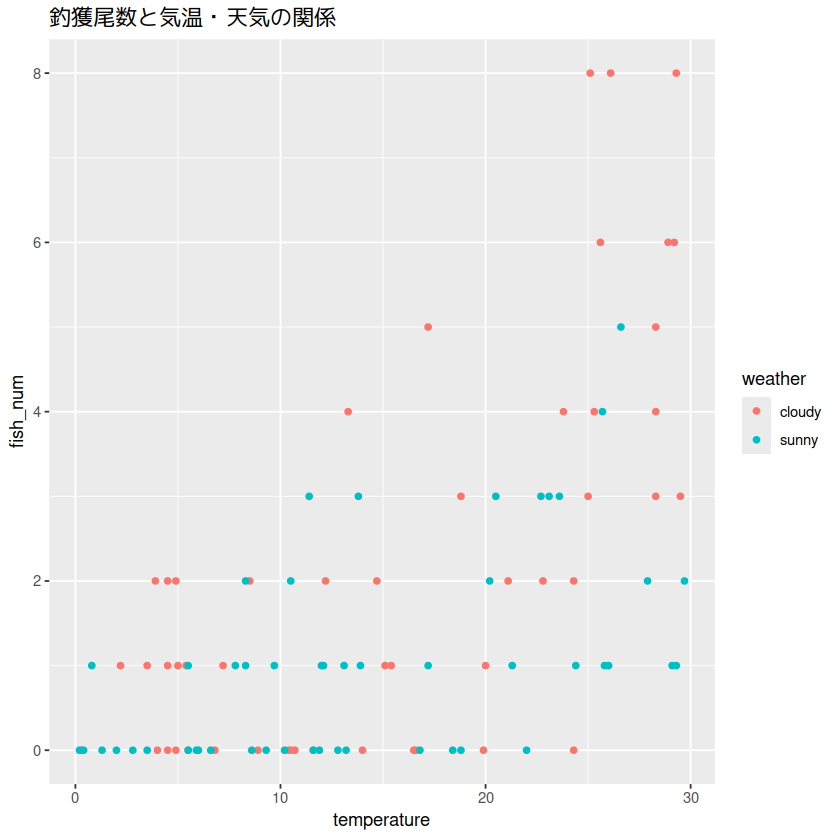

In [7]:
ggplot(
  data = fish_num_climate,
  mapping = aes(x = temperature, y = fish_num)
) +
  geom_point(aes(color = weather)) +
  labs(title = "釣獲尾数と気温・天気の関係")


In [8]:
glm_pois_brms <- brm(
  formula = fish_num ~ weather + temperature,
  family = poisson(),
  data = fish_num_climate,
  seed = 1,
  prior = c(set_prior("", class = "Intercept"))
)


Compiling Stan program...

Start sampling



In [9]:
glm_pois_brms


 Family: poisson 
  Links: mu = log 
Formula: fish_num ~ weather + temperature 
   Data: fish_num_climate (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.80      0.24    -1.30    -0.33 1.00     2320     2100
weathersunny    -0.59      0.17    -0.93    -0.26 1.00     2617     2670
temperature      0.08      0.01     0.06     0.10 1.00     2493     2372

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

Warning message:
“Method 'marginal_effects' is deprecated. Please use 'conditional_effects' instead.”


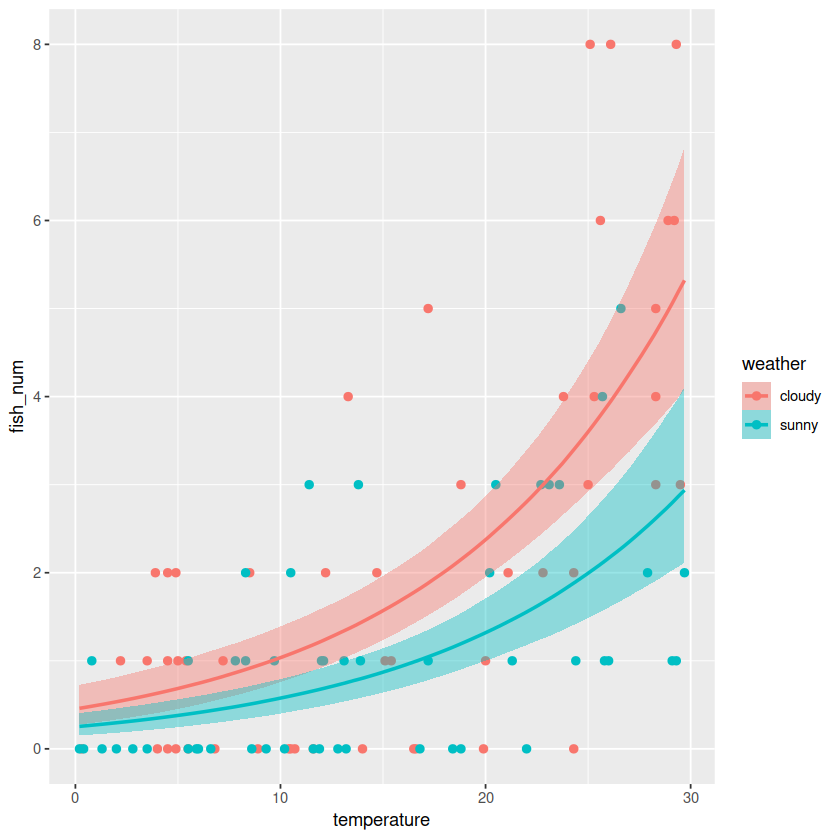

In [11]:
eff <- marginal_effects(
  glm_pois_brms,
  effects = "temperature:weather"
)
plot(eff, points = TRUE)


Warning message:
“Method 'marginal_effects' is deprecated. Please use 'conditional_effects' instead.”
Warning message:
“Argument 'probs' is deprecated. Please use 'prob' instead.”


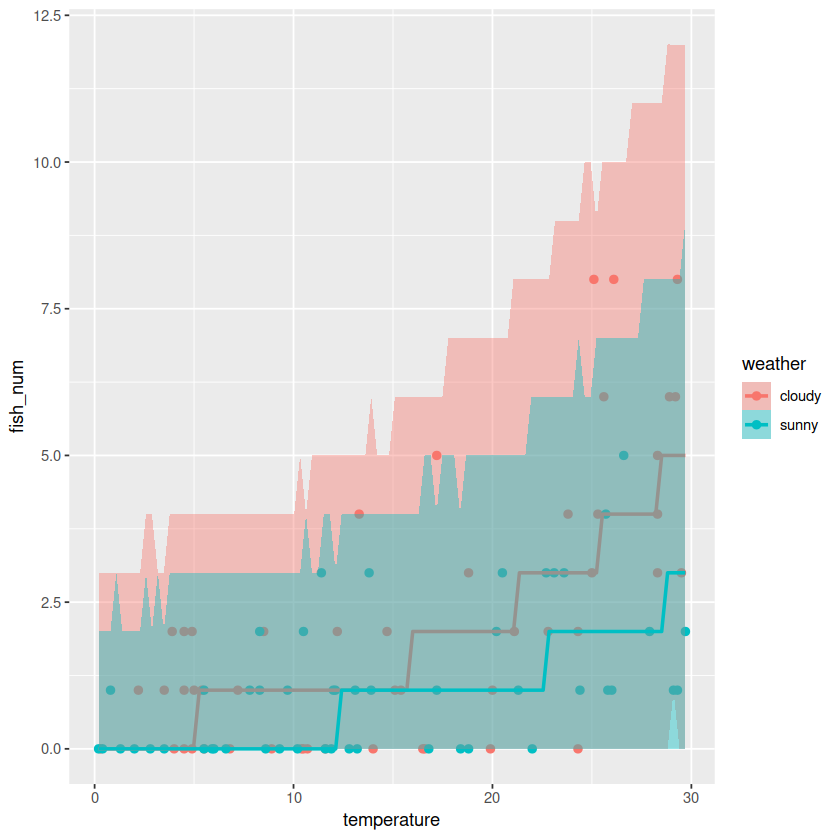

In [12]:
set.seed(1)
eff_pre <- marginal_effects(
  glm_pois_brms,
  method = "predict",
  effects = "temperature:weather",
  probs = c(0.005, 0.995)
)
plot(eff_pre, points = TRUE)


In [13]:
# stanを使って作成
# デザイン行列の作成
formula_pois <- formula(fish_num ~ weather + temperature)
design_mat <- model.matrix(formula_pois, fish_num_climate)
